# Adventures in Financial Time Series

## Igor Rivin

### Abstract

In this article we examine some macroeconomic data over the last several decades, and see if we can we can find anything interesting. In particular, we investigate how macroeconomic data affects equity prices. Our source of macroeconomic data is the St Louis Fed, via their very nice [API](http://api.stlouisfed.org). Our source of end of day S&P index data is [Yahoo! Finance](http://finance.yahoo.com). Our source of older (lower frequency) S&P price data, as well as dividends data, corporate earnings, and the CPI is [Robert Shillers wonderful resource](http://www.econ.yale.edu/~shiller/data.htm)

## Introduction

This paper is completely self-contained, First, we will set up our tools, then we will download and comment on macroeconoic data. Then, we will use some simple (but surprisingly effective) methods to develop a macro-based strategy, and then we will take a look at the longer-term data and make a couple of random comments.

## Tools

For our first act we will set up our tools. Luckily, a lot of the statistical analysis and graphics tools come as nicely packaged libraries in **Python**. Let's load them.

import os
import time
import pandas as pd
import numpy as np
import sklearn.linear_model
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import sys

In [3]:
%matplotlib inline

In [55]:
from IPython.display import display, HTML

Now we write the one home-brew function, which allows us to read a time series from the St Louis Fed, extract the right fields, and give it a name. We arbitrarily pick a start date (most Fed time series go to the mid-fifties or late forties, so our date of 7/1/1954 is in that range).

In [4]:
myapikey = '91c6e96d21f86b0932368859c1f6bc3f'

In [6]:
def read_series(sname, colname=None, startdate='1954-07-01', api_key= myapikey):
    if colname is None:
        colname = sname
    rootst = 'https://api.stlouisfed.org/fred/series/observations?series_id='
    endstr = '&api_key='+ api_key + '&file_type=json'
    theurl = rootst + sname + endstr
    theout = pd.read_json(theurl)
    thevals = pd.DataFrame(list(theout.observations))
    thevals.date = pd.to_datetime(thevals.date)
    thevals.set_index('date', inplace=True)
    alldays = pd.date_range(start=startdate, end=pd.Timestamp.today())
    thevals = thevals.reindex(alldays, method='ffill')
    thevals = thevals[['value']]
    thevals.value = pd.to_numeric(thevals.value, errors='coerce')
    thevals.columns = [colname]
    return thevals

First, we read the macro data from the St Louis Fed database, starting with the historic Fed Funds rate.

### Fed Funds Rate

In [7]:
ff = read_series('FEDFUNDS')

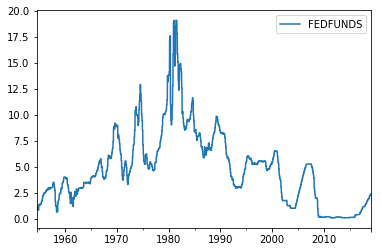

In [8]:
ff.plot()

The only thing that seems clear from the plot above is that the Fed (with all due respect) does not quite know what it is doing and is flying by the seat of the pants. Notice that what seems to happen is that the Fed spikes the funds rate, this causes a recession (by popping whatever the going asset bubble is), and then the Fed furiously back-pedals and creates the *next* asset bubble. We also see very clearly the ten years of ZIRP, for the first (but, very likely, not the last) time. The one exception is the huge spike in the early 1980s, where the Fed *created* a recession (under the leadership of Paul Volcker) to combat inflation.

Our next time series is the unemployment rate.

### Unemployment rate

In [9]:
ur = read_series('UNRATE', 'unemployment_rate')

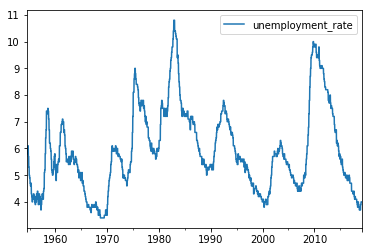

In [10]:
ur.plot()

The unemployment rate (to this author) is surprisingly volatile, and does seem to have a very cyclic pattern (again, indicating the ineffectiveness of the state control of this very important metric). 

Let's use the Fourier Transform to see how cyclic the series really is.

In [11]:
from scipy.fftpack import fft

First, let's count the samples:

In [13]:
N = len(ur)

Sample spacing is 1/365.25

In [14]:
T = 1/365.25

The scale:

In [15]:
x = np.linspace(0.0, N*T, N)

In [16]:
y = ur.values

In [17]:
yf = fft(y)

In [20]:
len(yf)

23615

In [18]:
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

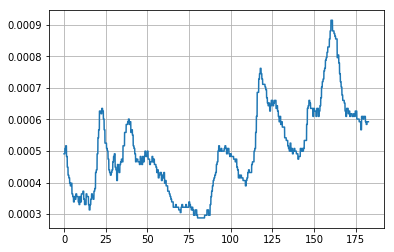

In [19]:
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

We do see a couple of characteristic frequencies, but both fairly long (120 and 160 *years*). At a shorter range, the energy is concentrated in a 24 and around a 40 year cycle.

Our next series has to do with the GDP. We don't want the actual GDP, but its year-on-year change, and we want it in "real" (whatever that means) dollars. So, that's what we ask for.

### GDP

In [22]:
gdp = read_series('GDPC1&units=pc1', 'real_gdp_growth')

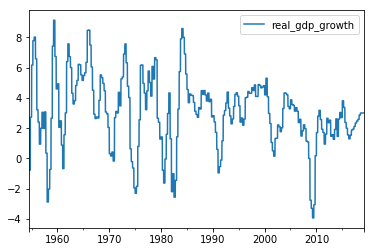

In [23]:
gdp.plot()

The graph is quite noisy again, but it does seem to be trending down. We can check.

In [24]:
gdpreg = sklearn.linear_model.LinearRegression()

In [27]:
gdpreg.fit(np.array(range(len(gdp))).reshape(-1, 1), gdp.values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [28]:
gdpreg.coef_

array([[-8.75823991e-05]])

So, we do, indeed, see a decline of 0.00009% a day, or about 1% every thirty years. This is quite nontrivial, though there is hope that the recent reboot of the economy (including the tax code) might reverse this trend.

### Corporate profit after tax

In [29]:
cp = read_series('CP&units=pc1', 'corporate_profit_after_tax')

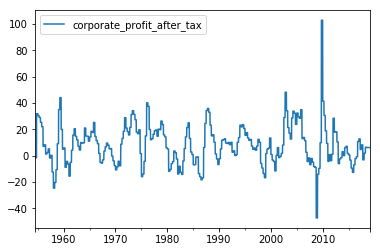

In [30]:
cp.plot()

**Remark** The above time series is *not* inflation-adjusted.

### Personal Savings Rate

In [31]:
ps = read_series('PSAVERT', 'personal_savings_rate')

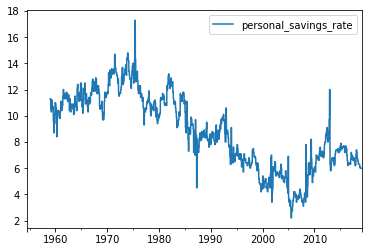

In [32]:
ps.plot()

The personal savings rate is (not surprisingly) not very noisy, but 

a. Shows a persistent downward trend.

b. Spikes during recessions.

The two items are presumably related, since the savings rate must have spiked very high during the Great Depression, and it took it a long time to come down. There is also the question of whether the savings rate includes housing payments, since starting in around 1980, the mortgage tax deduction was introduced, and that had the obvious effect of causing people (arguably, rather stupidly) to invest in housing.

### Treasuries

In [33]:
treas = read_series('DGS10', 'treasury_rate')

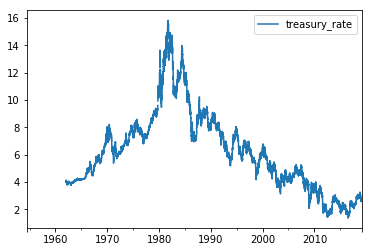

In [34]:
treas.plot()

The long bond, for obvious reasons, tracks Fed Funds, though it is amusing to see the yield curve inversion during the Volcker recession (where the Fed Funds was **higher** than the long bond.

### Personal consumption

In [35]:
rpcec = read_series('DPCERL1Q225SBEA', 'Real_personal_consumption')

This series shows the *change* in personal consumption rates year over year (in constant dollars), and, as such, should be closely correlated to the real GDP growth. Whether or not it is, we shall see below.

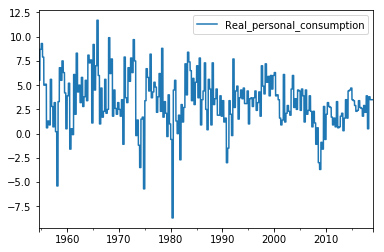

In [36]:
rpcec.plot()

### Inflation

In [37]:
inflation = read_series('FPCPITOTLZGUSA', 'inflation_CPI')

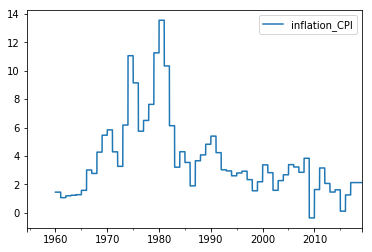

In [38]:
inflation.plot()

We see that the Fed has been successful in keeping the inflation in roughly 3% range, with the notable 20 year exception of late 1960s to mid 1980s. This means that the currency is debased by a factor of _at least_ 20 per century.

### Nonfarm payrolls

Our next series is the year-on-year change in nonfarm payrolls. This series, again, is far more volatile than one might have suspected, and seems to be trending down (regression bears this out - the growth is decaying by around 0.02% a year). What is more interesting, however,if we look at the cumulative graph, is that the numbers plateaued from around 1998 to around 2014. During that same period the population of the country grew by [over 15%](http://www.multpl.com/united-states-population/table) , which suggests a catastrophic growth in unemployment (usually disguised as the a decrease in "labor participation rate".)

In [39]:
payems = read_series('PAYEMS&units=pc1', 'total_nonfarm_payroll')

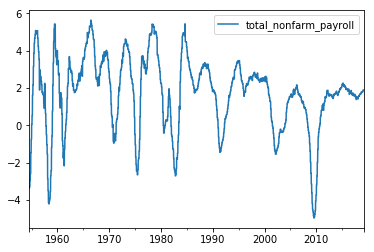

In [40]:
payems.plot()

In [47]:
paymod = sklearn.linear_model.LinearRegression()
paymod.fit(np.array(range(len(payems))).reshape(-1, 1), payems.values)
paymod.coef_ * 365

array([[-0.0234402]])

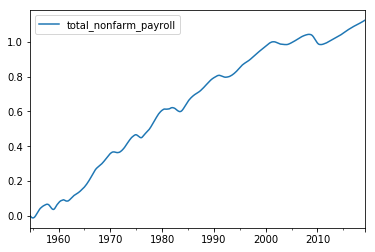

In [44]:
(payems/36525).cumsum().plot()

## Macro Summary

Now, let us combine our Fed macro data into one dataframe:

In [48]:
feddata = pd.concat([ff, ur, payems, inflation, rpcec, cp, treas, ps, gdp], axis=1)

We want corporate profits to be inflation adjusted...

In [49]:
feddata['real_profits'] = ((1+feddata.corporate_profit_after_tax/100)/(1+feddata.inflation_CPI/100)-1)*100

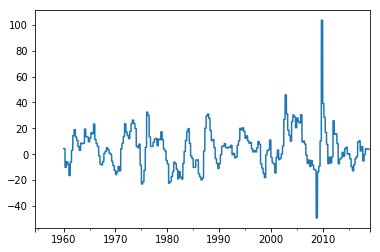

In [50]:
feddata.real_profits.plot()

And now we can drop the unadjusted profits.

In [51]:
feddata.drop('corporate_profit_after_tax', axis=1, inplace = True)

In [52]:
feddata.describe()

,FEDFUNDS,unemployment_rate,total_nonfarm_payroll,inflation_CPI,Real_personal_consumption,treasury_rate,personal_savings_rate,real_gdp_growth,real_profits
count,23615.000000,23615.000000,23616.000000,21605.000000,23615.000000,20016.000000,21970.000000,23615.000000,21605.000000
mean,4.808309,5.920373,1.738336,3.743822,3.340394,6.175855,8.804069,3.081308,4.308444
std,3.601653,1.577415,1.996919,2.767543,2.774571,2.873894,2.847440,2.350440,14.833696
min,0.070000,3.400000,-4.961890,-0.355546,-8.700000,1.370000,2.200000,-3.924450,-49.217963
25%,2.090000,4.800000,0.804320,1.898048,1.800000,4.110000,6.600000,1.825690,-5.792142
50%,4.590000,5.600000,1.921960,3.015075,3.400000,5.920000,8.700000,3.035910,4.220086
75%,6.540000,7.000000,3.002990,4.300535,4.900000,7.810000,11.200000,4.466340,11.633006
max,19.100000,10.800000,5.636840,13.549202,11.700000,15.840000,17.300000,9.127060,103.521664


And, both as a sanity check and for enlightenment, let's compute the correlations:

In [56]:
display(feddata.corr())

,FEDFUNDS,unemployment_rate,total_nonfarm_payroll,inflation_CPI,Real_personal_consumption,treasury_rate,personal_savings_rate,real_gdp_growth,real_profits
FEDFUNDS,1.000000,0.068239,0.234673,0.760570,-0.079506,0.902514,0.434645,0.042756,-0.237909
unemployment_rate,0.068239,1.000000,-0.487445,0.140814,-0.089492,0.298355,0.146974,-0.331832,0.008044
total_nonfarm_payroll,0.234673,-0.487445,1.000000,0.084193,0.228841,0.099238,0.225649,0.770092,0.158032
inflation_CPI,0.760570,0.140814,0.084193,1.000000,-0.221978,0.667293,0.456973,-0.182112,-0.210656
Real_personal_consumption,-0.079506,-0.089492,0.228841,-0.221978,1.000000,0.022983,0.113223,0.515216,0.181618
treasury_rate,0.902514,0.298355,0.099238,0.667293,0.022983,1.000000,0.450290,0.041934,-0.187082
personal_savings_rate,0.434645,0.146974,0.225649,0.456973,0.113223,0.450290,1.000000,0.144524,-0.106013
real_gdp_growth,0.042756,-0.331832,0.770092,-0.182112,0.515216,0.041934,0.144524,1.000000,0.413069
real_profits,-0.237909,0.008044,0.158032,-0.210656,0.181618,-0.187082,-0.106013,0.413069,1.000000


Let's look at the larger (in absolute value) correlations: In the first column, it is not at all surprising that Fed Funds is highly correlated with the treasury rate. It is not surprising that the Fed Funds rate is correlated with inflation (since the Fed typically raises the rate when it judges the inflation as too high). High Fed Funds rate tends to come with economy close to "overheating" (whatever that means), and so it is not surprising to find it correlated with the growth of payrolls. What is somewhat puzzling is the **_negative_** correlation of Fed Funds with the growth of profits. On reflection, though, cheap money make borrowing money cheap, and contribute to profits. The last suprsing number is the high correlatio of personal savings rate and Fed Funds, since before we seem to have noticed that personal savings rate is high in recessionary times, when Fed Funds tends to be low. A bit of a reflection brings forth a theory:

>Personal savings rate was higher in the beginning of our period, when the Fed had not yet fallen >prey to quantitative easing and ZIRP as it had later. 

We can test this theory, by looking at the second half of our DataFrame.

In [54]:
feddata.iloc[12000:].corr()

,FEDFUNDS,unemployment_rate,total_nonfarm_payroll,inflation_CPI,Real_personal_consumption,treasury_rate,personal_savings_rate,real_gdp_growth,real_profits
FEDFUNDS,1.000000,-0.447434,0.416536,0.717356,0.178571,0.892080,0.101945,0.377241,-0.078243
unemployment_rate,-0.447434,1.000000,-0.524610,-0.204964,-0.297694,-0.181305,0.363767,-0.435987,0.250490
total_nonfarm_payroll,0.416536,-0.524610,1.000000,0.284495,0.432697,0.254422,0.111017,0.771993,-0.113662
inflation_CPI,0.717356,-0.204964,0.284495,1.000000,-0.074471,0.698508,0.130924,0.192212,-0.089661
Real_personal_consumption,0.178571,-0.297694,0.432697,-0.074471,1.000000,0.174499,-0.028098,0.628781,0.106612
treasury_rate,0.892080,-0.181305,0.254422,0.698508,0.174499,1.000000,0.280693,0.320235,0.084284
personal_savings_rate,0.101945,0.363767,0.111017,0.130924,-0.028098,0.280693,1.000000,-0.000448,-0.056383
real_gdp_growth,0.377241,-0.435987,0.771993,0.192212,0.628781,0.320235,-0.000448,1.000000,0.174883
real_profits,-0.078243,0.250490,-0.113662,-0.089661,0.106612,0.084284,-0.056383,0.174883,1.000000


Sure enough, the correlation recedes to a much lower 0.1.

The other large (and small) values are not too surprising. One interesting one is the **unemployment rate**. You will notice that in the full data frame there is very low correlation between the Fed Funds rate and the Unemployment rate, whereas in the second half of the time series there is a very **_strong_** (negative) correlation. A plausible argument is that the Fed's charter has mutated over the years to deal with unemployment as well as with inflation, especially as the inflation has stayed low over the last thirty-odd years.

## Macro effects on equity prices

We now download S&P 500 adjusted close prices. Note that these do *not* keep track of dividends, so we will need to use multiple data sets.

In [57]:
sandp500 = pd.read_csv(os.path.normpath('C:/Users/rivin/Downloads/^GSPC (1).csv'),index_col=['Date'], parse_dates=['Date'])

In [58]:
sandp2=sandp500.resample('D').asfreq().fillna(method='ffill')

In [59]:
sandpa = sandp2[['Adj Close']]

In [60]:
sandpa.columns = ['ac']

Robert Shiller's S&P 500 data. Shiller has his data as an Excel file, which gives pandas some difficulties, so we read in a lightly edited version, and adjust a couple of things.

In [61]:
shillerd = pd.read_csv(os.path.normpath('C:/Users/rivin/Documents/ie_data2.csv'), parse_dates=['Date'])

In [62]:
shillerd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2415 entries, 0 to 2414
Data columns (total 11 columns):
Date         1777 non-null datetime64[ns]
P            1778 non-null object
D            1776 non-null float64
E            1773 non-null float64
CPI          1778 non-null object
Fraction     1777 non-null float64
Rate GS10    1778 non-null object
Price        1777 non-null float64
Dividend     1776 non-null float64
Earnings     1773 non-null float64
CAPE         1657 non-null float64
dtypes: datetime64[ns](1), float64(7), object(3)
memory usage: 207.6+ KB


In [63]:
shillerd.set_index('Date', inplace=True)

In [64]:
shillerd.dropna(inplace = True)

In [65]:
shillerd=shillerd.loc[:'2019-02-01']

In [66]:
shiller = shillerd.resample('D').pad()

In [67]:
shiller.P = pd.to_numeric(shiller.P)
shiller.CPI = pd.to_numeric(shiller.CPI)

Compute dividend in percentage terms.

In [68]:
shiller['perdiv'] = shiller.D/(365 * shiller.P)

CAPE (or the Shiller P/E ratio) is a smoothed (over 10 years) version of the price to earnings ratio. Notice that even with the smoothing it is a bit feverish.

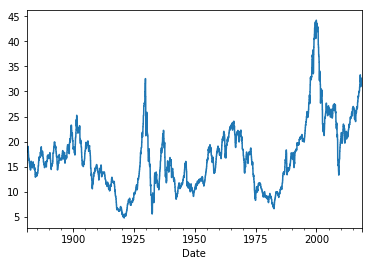

In [69]:
shiller.CAPE.plot()

In [70]:
newf = pd.concat([sandpa, shiller[['perdiv', 'CAPE']]], axis=1)

In [71]:
newsandpa = newf.fillna(method='ffill').dropna()

We can now combine the actual return and the dividend yield to get the true return.

In [72]:
newsandpa['totret']=newsandpa.ac.pct_change() + newsandpa.perdiv

Now we combine the macro data and the equities data.

In [73]:
alldata = pd.concat([newsandpa, feddata], axis=1).dropna()

And now we adjust the returns by the inflation rate and also by the treasury rate. If we were running a hedge fund, our incentive allocation is computed on the outperformance of the benchmark (typically the treasury rate).

In [74]:
alldata['trueac'] = alldata.totret - alldata.inflation_CPI/36500
alldata['treasac'] = alldata.totret - alldata.treasury_rate/36500

In [75]:
alldata.drop('ac', axis=1, inplace=True)

In [76]:
alldata.corr()

,perdiv,CAPE,totret,FEDFUNDS,unemployment_rate,total_nonfarm_payroll,inflation_CPI,Real_personal_consumption,treasury_rate,personal_savings_rate,real_gdp_growth,real_profits,trueac,treasac
perdiv,1.000000,-0.901931,-0.001008,0.718015,0.385585,0.120645,0.706435,-0.062806,0.764392,0.732126,-0.054338,-0.207967,-0.007349,-0.008117
CAPE,-0.901931,1.000000,0.001608,-0.544538,-0.558607,-0.002250,-0.604356,0.114611,-0.645656,-0.658984,0.119037,0.058704,0.007033,0.007612
totret,-0.001008,0.001608,1.000000,-0.006237,0.014149,-0.007927,-0.008311,0.012295,-0.002319,-0.000567,-0.002178,0.001384,0.999960,0.999957
FEDFUNDS,0.718015,-0.544538,-0.006237,1.000000,0.046488,0.219751,0.756193,-0.066036,0.902531,0.465697,0.040869,-0.253655,-0.013025,-0.014631
unemployment_rate,0.385585,-0.558607,0.014149,0.046488,1.000000,-0.496697,0.144827,-0.096991,0.297455,0.148795,-0.332190,0.010244,0.012848,0.011382
total_nonfarm_payroll,0.120645,-0.002250,-0.007927,0.219751,-0.496697,1.000000,0.068530,0.278996,0.099350,0.243402,0.781629,0.146493,-0.008542,-0.008851
inflation_CPI,0.706435,-0.604356,-0.008311,0.756193,0.144827,0.068530,1.000000,-0.231322,0.667186,0.489560,-0.192846,-0.230006,-0.017287,-0.014515
Real_personal_consumption,-0.062806,0.114611,0.012295,-0.066036,-0.096991,0.278996,-0.231322,1.000000,0.023076,0.112016,0.512022,0.172476,0.014370,0.012080
treasury_rate,0.764392,-0.645656,-0.002319,0.902531,0.297455,0.099350,0.667186,0.023076,1.000000,0.449770,0.041925,-0.187244,-0.008308,-0.011619
personal_savings_rate,0.732126,-0.658984,-0.000567,0.465697,0.148795,0.243402,0.489560,0.112016,0.449770,1.000000,0.138756,-0.097964,-0.004962,-0.004750


We see that our returns columns ('trueac' and 'treasac') have very low correlation with the macro statistcs. We can smooth the data and see whether we can get better results. No sooner said than done - we will use exponential moving average with a 90 day decay rate. Before we do, let's note the strangely high (in absolute value) correlation between CAPE and dividend payouts. A natural conjecture is that a roughly constant percentage of the earnings is paid out as dividends. Let us check:

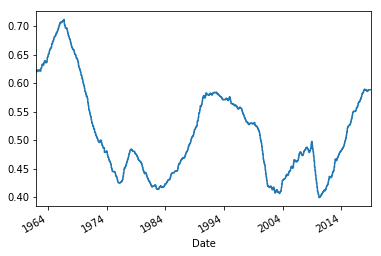

In [88]:
(365*alldata.perdiv*alldata.CAPE).plot()

We see that this conjecture is accurate - the ratio between the high and low ratio of payout ranges in a relative narrow range between 0.4 and 0.7. The ratio tends to go up in boom times and to drop in recessions, which certainly stands to reason, but also suggests that we should look at earnings over price:

In [96]:
alldata['CAPEinverse'] = 1/alldata.CAPE

In [97]:
alldata.drop('CAPE', axis=1, inplace=True)

In [98]:
alldata.corr()

,perdiv,totret,FEDFUNDS,unemployment_rate,total_nonfarm_payroll,inflation_CPI,Real_personal_consumption,treasury_rate,personal_savings_rate,real_gdp_growth,real_profits,trueac,treasac,CAPEinverse
perdiv,1.000000,-0.001008,0.718015,0.385585,0.120645,0.706435,-0.062806,0.764392,0.732126,-0.054338,-0.207967,-0.007349,-0.008117,0.944395
totret,-0.001008,1.000000,-0.006237,0.014149,-0.007927,-0.008311,0.012295,-0.002319,-0.000567,-0.002178,0.001384,0.999960,0.999957,0.000106
FEDFUNDS,0.718015,-0.006237,1.000000,0.046488,0.219751,0.756193,-0.066036,0.902531,0.465697,0.040869,-0.253655,-0.013025,-0.014631,0.713279
unemployment_rate,0.385585,0.014149,0.046488,1.000000,-0.496697,0.144827,-0.096991,0.297455,0.148795,-0.332190,0.010244,0.012848,0.011382,0.553658
total_nonfarm_payroll,0.120645,-0.007927,0.219751,-0.496697,1.000000,0.068530,0.278996,0.099350,0.243402,0.781629,0.146493,-0.008542,-0.008851,-0.013269
inflation_CPI,0.706435,-0.008311,0.756193,0.144827,0.068530,1.000000,-0.231322,0.667186,0.489560,-0.192846,-0.230006,-0.017287,-0.014515,0.730168
Real_personal_consumption,-0.062806,0.012295,-0.066036,-0.096991,0.278996,-0.231322,1.000000,0.023076,0.112016,0.512022,0.172476,0.014370,0.012080,-0.104597
treasury_rate,0.764392,-0.002319,0.902531,0.297455,0.099350,0.667186,0.023076,1.000000,0.449770,0.041925,-0.187244,-0.008308,-0.011619,0.797433
personal_savings_rate,0.732126,-0.000567,0.465697,0.148795,0.243402,0.489560,0.112016,0.449770,1.000000,0.138756,-0.097964,-0.004962,-0.004750,0.597035
real_gdp_growth,-0.054338,-0.002178,0.040869,-0.332190,0.781629,-0.192846,0.512022,0.041925,0.138756,1.000000,0.402070,-0.000446,-0.002567,-0.139361


Now back to smoothing.

First, a little cleanup.

In [99]:
outputs = alldata[['treasac']]

In [100]:
inputs = alldata.drop(['treasac', 'totret', 'trueac'], axis=1)

In [101]:
outputs['smoothed']=outputs.treasac.ewm(90).mean()

C:\ProgramData\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [102]:
pd.concat([inputs, outputs], axis=1).corr()

,perdiv,FEDFUNDS,unemployment_rate,total_nonfarm_payroll,inflation_CPI,Real_personal_consumption,treasury_rate,personal_savings_rate,real_gdp_growth,real_profits,CAPEinverse,treasac,smoothed
perdiv,1.000000,0.718015,0.385585,0.120645,0.706435,-0.062806,0.764392,0.732126,-0.054338,-0.207967,0.944395,-0.008117,-0.217151
FEDFUNDS,0.718015,1.000000,0.046488,0.219751,0.756193,-0.066036,0.902531,0.465697,0.040869,-0.253655,0.713279,-0.014631,-0.139153
unemployment_rate,0.385585,0.046488,1.000000,-0.496697,0.144827,-0.096991,0.297455,0.148795,-0.332190,0.010244,0.553658,0.011382,0.080357
total_nonfarm_payroll,0.120645,0.219751,-0.496697,1.000000,0.068530,0.278996,0.099350,0.243402,0.781629,0.146493,-0.013269,-0.008851,-0.027674
inflation_CPI,0.706435,0.756193,0.144827,0.068530,1.000000,-0.231322,0.667186,0.489560,-0.192846,-0.230006,0.730168,-0.014515,-0.173268
Real_personal_consumption,-0.062806,-0.066036,-0.096991,0.278996,-0.231322,1.000000,0.023076,0.112016,0.512022,0.172476,-0.104597,0.012080,0.284899
treasury_rate,0.764392,0.902531,0.297455,0.099350,0.667186,0.023076,1.000000,0.449770,0.041925,-0.187244,0.797433,-0.011619,-0.093313
personal_savings_rate,0.732126,0.465697,0.148795,0.243402,0.489560,0.112016,0.449770,1.000000,0.138756,-0.097964,0.597035,-0.004750,-0.118206
real_gdp_growth,-0.054338,0.040869,-0.332190,0.781629,-0.192846,0.512022,0.041925,0.138756,1.000000,0.402070,-0.139361,-0.002567,0.095994
real_profits,-0.207967,-0.253655,0.010244,0.146493,-0.230006,0.172476,-0.187244,-0.097964,0.402070,1.000000,-0.193885,0.003126,0.090888


We see that smoothing has, indeed, removed a lot of random noies, and so the correlation between the smoothed returns and the inputs are quite visible (and the correlation of the **'treasac'** and **'smoothed'** columns tells us that we have removed around 6/7 of the noise (or, at least, we hope it's noise).

For our next act, we will see if the macroeconomic inputs predict the outputs. Before we can run a regression, we should make sure that the inputs are scaled properly.

In [105]:
mms = MinMaxScaler()

In [106]:
scaled_inputs = mms.fit_transform(inputs)

In [107]:
newreg = sklearn.linear_model.LinearRegression()

In [108]:
newreg.fit(scaled_inputs, outputs['smoothed'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [116]:
newreg.coef_ *365

array([-0.03410373,  0.26331472,  0.55958525,  0.18154696,  0.19202823,
        0.53894967,  0.03214564,  0.01667201, -0.09906729, -0.01608105,
       -0.79923699])

We multiplied the regression coefficients by 365 to regress the annualized (log) return. The astute reader will note that out of the 11 coefficients, six are much larger than the others in absolute values. These are: Fed Funds, unemployment rate, total nonfarm payrolls, inflation, real personal consumption, and (Shiller-smoothed) earnings/price ratio. The fact that *high* CAPE is positively correlated with returns is surprising, and tells us that there is a strong momentum component in stock prices.

In [115]:
np.sqrt(newreg.score(scaled_inputs, outputs['smoothed']))

0.45152485568521045

We seem to be explaining about 18% of the variance, but in a quest for robustness, let us drop the less weighty columns.

In [117]:
min_inputs = inputs[['FEDFUNDS', 'unemployment_rate', 'total_nonfarm_payroll', 'inflation_CPI', 'Real_personal_consumption','CAPEinverse']]

In [118]:
mms2 = MinMaxScaler()

In [119]:
scaled_min = mms2.fit_transform(min_inputs)

In [120]:
minreg = sklearn.linear_model.LinearRegression()

In [121]:
minreg.fit(scaled_min, outputs['smoothed'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [123]:
minreg.coef_ * 365

array([ 0.27790201,  0.5503074 ,  0.09963687,  0.21041448,  0.51108641,
       -0.80664862])

In [124]:
np.sqrt(minreg.score(scaled_min, outputs['smoothed']))

0.44972794932305243

We see that there is very little degradation in performance, while the number of predictor variables is half. Success! Let's see if we can push this further, and leave only the three biggest regression coefficients:

In [126]:
super_min_inputs = inputs[[ 'unemployment_rate',  'Real_personal_consumption','CAPEinverse']]

In [127]:
mms3 = MinMaxScaler()

In [128]:
scaled_super_min = mms3.fit_transform(super_min_inputs)

In [129]:
sminreg = sklearn.linear_model.LinearRegression()

In [130]:
sminreg.fit(scaled_super_min, outputs['smoothed'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [132]:
sminreg.coef_*365

array([ 0.29614105,  0.48552467, -0.34033717])

In [133]:
np.sqrt(sminreg.score(scaled_super_min, outputs['smoothed']))

0.4033901452283351

We see that the correlation is slightly lower, but the much greater simplicity may well make the model far more robust. Let us see how this model performs.

In [134]:
preds = sminreg.predict(scaled_super_min)

In [137]:
testdf = pd.concat([outputs[['treasac']], pd.DataFrame(preds, index=outputs.index)], axis=1)

In [138]:
testdf.columns = ['treasac', 'preds']

In [142]:
(365*testdf).describe()

,treasac,preds
count,19999.000000,19999.000000
mean,0.038868,0.036276
std,3.089513,0.092043
min,-74.774713,-0.395983
25%,-0.780802,-0.011685
50%,-0.029294,0.048306
75%,1.026694,0.095997
max,39.370596,0.224511


Now let us see what happens when we buy when the predicted value is a fair bit bigger than its median value, and sell if it is a fair bit *below* the median value (and stay in cash otherwise - in fact, this is an underestimate, since we would be in treasuries, and make some money):

In [174]:
testdf['regressed'] = testdf.apply(lambda x:x['treasac'] if x['preds']>0.0002 else -x['treasac'] if x['preds']<-0.0002else 0, axis=1)

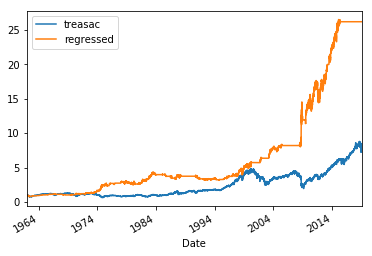

In [178]:
np.exp(testdf[['treasac', 'regressed']].cumsum()).plot()

We see that we would outperform the market by close to a factor of five (over 55 years). To drive the point home, let us see how the "above the median" and "below the median" periods are distributed.

In [151]:
testdf['cumret']=testdf.treasac.cumsum()
testdf['col'] = testdf.preds.map(lambda x: 1.0 if x > 0.000132 else 0.0)

In [165]:
def scatterplot(x_data, y_data, color_data,x_label, y_label, title, colormap='viridis'):
    fig, ax = plt.subplots()
    ax.scatter(x_data, y_data, s=10,c = color_data, alpha = 0.75)

    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    fig.autofmt_xdate()

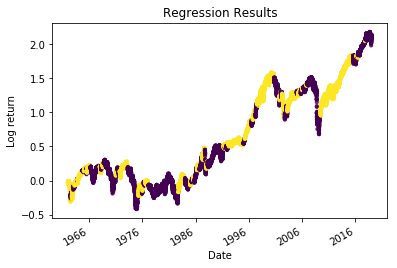

In [166]:
scatterplot(testdf.index, testdf.cumret, testdf.col, 'Date', 'Log return', 'Regression Results')

## Some general reflections

First, we look at the cumulative (log) of the (dividend reinvested) return of the S&P 500.

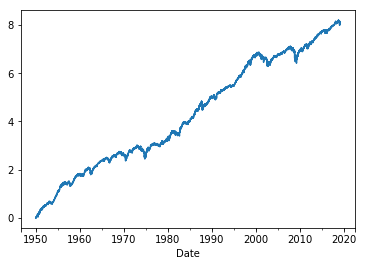

In [145]:
newsandpa.totret.cumsum().plot()

Looks awfully straight, so let's look at a longer history from the shiller data:

In [179]:
shiller['totret'] = shiller.P.pct_change() + shiller.perdiv

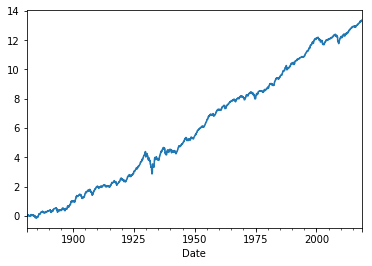

In [180]:
shiller.totret.cumsum().plot()

Still looks pretty straight... Let's do a regression, and see how straight...

In [181]:
shiller['dummy'] = list(range(len(shiller)))

In [182]:
shiller.dropna(inplace=True)

In [183]:
sreg = sklearn.linear_model.LinearRegression()

In [184]:
sreg.fit(shiller[['dummy']], shiller[['totret']].cumsum())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [185]:
sreg.coef_

array([[0.00028357]])

In [186]:
sreg.score(shiller[['dummy']], shiller[['totret']].cumsum())

0.9901422237103686

We see an $R^2$ of 99%.

The series above was not inflation adjusted...

In [187]:
shiller['deflated'] = shiller.totret.cumsum() - np.log(shiller.CPI)

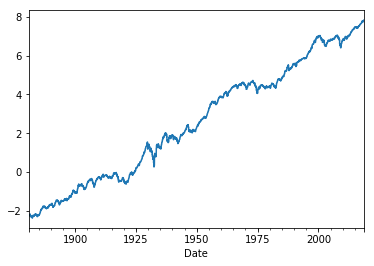

In [188]:
shiller.deflated.plot()

In [189]:
sreg = sklearn.linear_model.LinearRegression()

In [190]:
sreg.fit(shiller[['dummy']], shiller[['deflated']].cumsum())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [191]:
sreg.score(shiller[['dummy']], shiller[['deflated']].cumsum())

0.7789264906230998

We notice that the scare has gone way down, showing that the Fed's efforts to control inflation are having limited success.

In [192]:
shiller['inflation'] = shiller.CPI.pct_change()

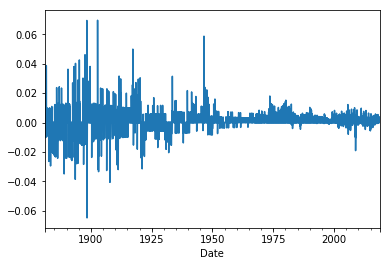

In [193]:
shiller.inflation.plot()

We see that the Fed (in the postwar years) has had great success in controlling *deflation* In truth, the volatility of the CPI has gone a fair bit down, but at the cost of a steady debasement of currency.

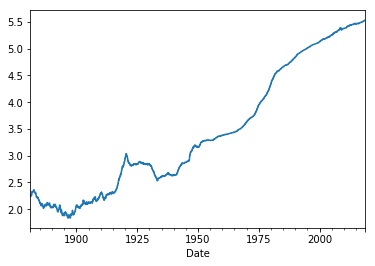

In [195]:
np.log(shiller.CPI).plot()

In post-war years, there is steady success in debasing the currency.